In [1]:
# Required for xgboost windows.
# See: https://www.ibm.com/developerworks/community/blogs/jfp/entry/Installing_XGBoost_For_Anaconda_on_Windows?lang=en
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-6.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [5]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns
import re
from mpl_toolkits.basemap import Basemap
from IPython.display import display # Allows the use of display() for DataFrames
# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

In [3]:
# Load training and testing datasets
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# Check dataset dimensions
print "Training set has {} rows and {} columns.".format(*df_train.shape)
print "Testing set has {} rows and {} columns.".format(*df_test.shape)

Training set has 878049 rows and 9 columns.
Testing set has 884262 rows and 7 columns.


# Data Exploration

In [4]:
# Show header and first few rows of training dataset
print "Training dataset sample:"
display(df_train.head())

# Show basic stats for numerical categories
print "Basic statistics for numerical data:"
display(df_train.describe())

# Check testing dataset
print "Testing dataset sample:"
display(df_test.head())

Training dataset sample:


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


Basic statistics for numerical data:


,X,Y
count,878049.000000,878049.000000
mean,-122.422616,37.771020
std,0.030354,0.456893
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416420,37.775421
75%,-122.406959,37.784369
max,-120.500000,90.000000


Testing dataset sample:


,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


Longitude (X) and latitude (Y) information


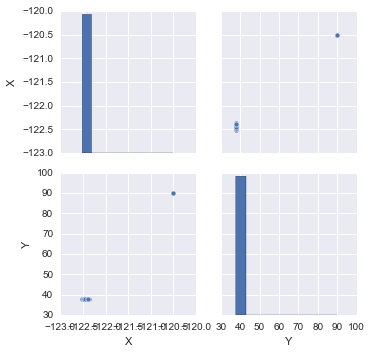

In [5]:
# Visualize longitude and latitude
print "Longitude (X) and latitude (Y) information"
sns.pairplot(df_train)

From the pairplot, it seems that there are a few anomalies in our data.
Namely, some of the latitude (Y) of the data points are +90 degrees. 
This means that location wise, these points are at the top of the earth! No where within the vicinity of SF Bay.
We will need to treat them as outliers and remove them.

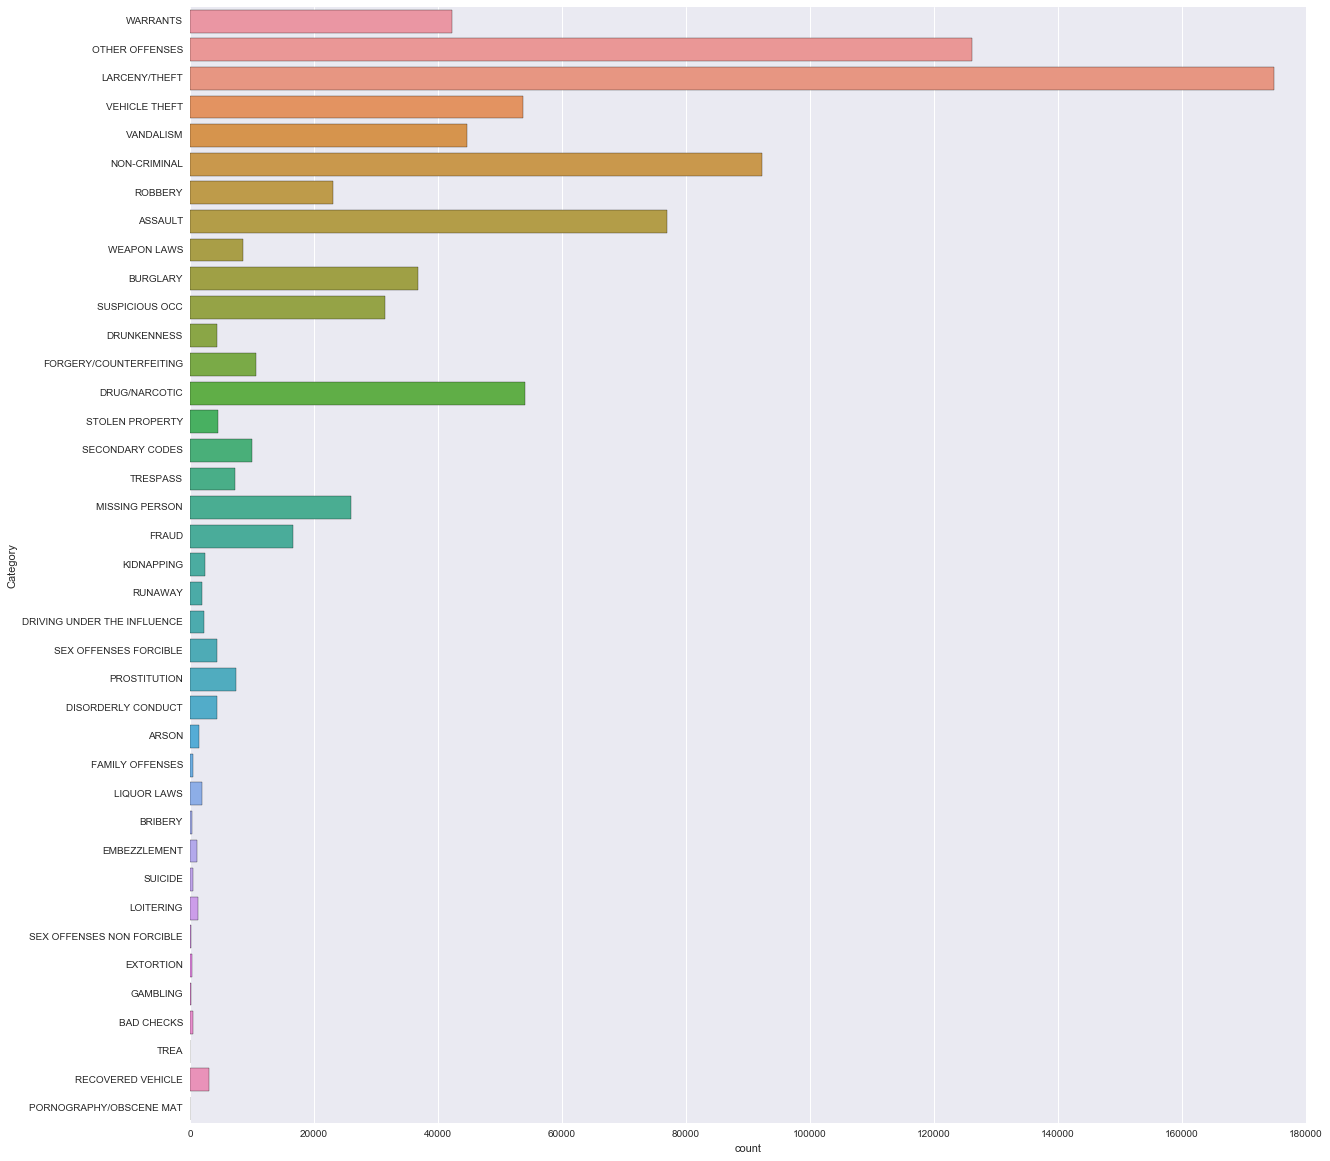

In [6]:
# Now for visualizing the categorical features
plt.figure(figsize=(20, 20))
sns.countplot(y=df_train['Category'], data=df_train)

LARCENY/THEFT     174900
OTHER OFFENSES    126182
NON-CRIMINAL       92304
ASSAULT            76876
DRUG/NARCOTIC      53971
VEHICLE THEFT      53781
VANDALISM          44725
WARRANTS           42214
BURGLARY           36755
SUSPICIOUS OCC     31414
Name: Category, dtype: int64


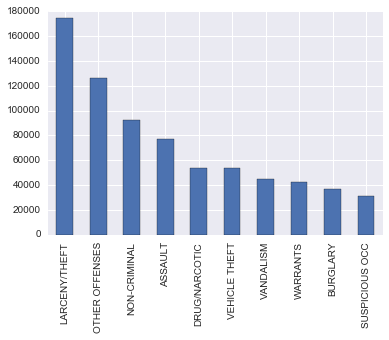

In [7]:
# Inspect the tpo 10 counts of Category
category_counts = df_train['Category'].value_counts()
print category_counts[:10]

# Plot the top 10 counts
category_counts[:10].plot(kind='bar')

The most common Category is LARCENY/THEFT.
Generally, the Category distribution is unbalanced.
This is the target variable to be predicted.
Care must be taken when choosing which performance metrics to use for our model later on

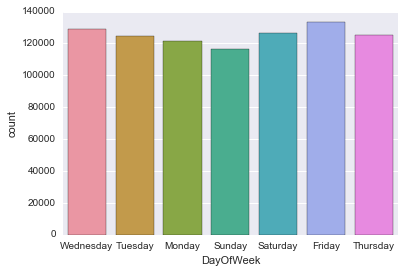

In [8]:
# Visualizing category: DayOfWeek
sns.countplot(x=df_train['DayOfWeek'], data=df_train)

The DaysOfWeek is a much more balanced distribution.

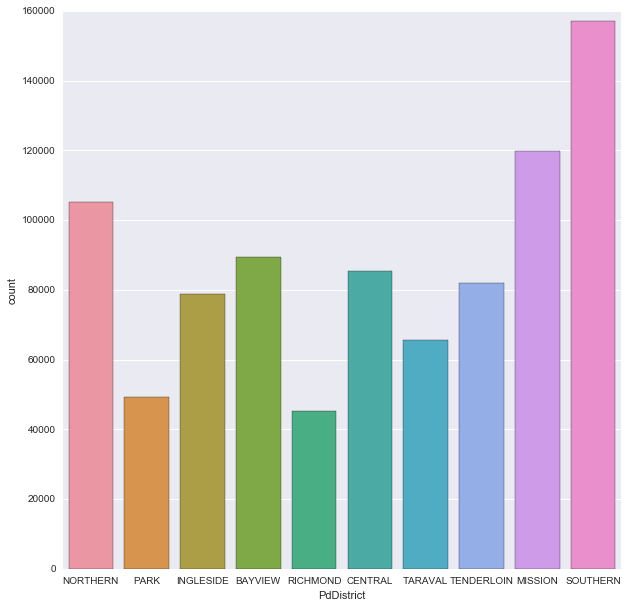

In [9]:
# Now, we try visualizing PdDistrict
plt.figure(figsize=(10, 10))
sns.countplot(x=df_train['PdDistrict'], data=df_train)

Locality-wise, it seems that the SOUTHERN police branch gets dispatched the most.

NONE                                      526790
ARREST, BOOKED                            206403
ARREST, CITED                              77004
LOCATED                                    17101
PSYCHOPATHIC CASE                          14534
UNFOUNDED                                   9585
JUVENILE BOOKED                             5564
COMPLAINANT REFUSES TO PROSECUTE            3976
DISTRICT ATTORNEY REFUSES TO PROSECUTE      3934
NOT PROSECUTED                              3714
Name: Resolution, dtype: int64


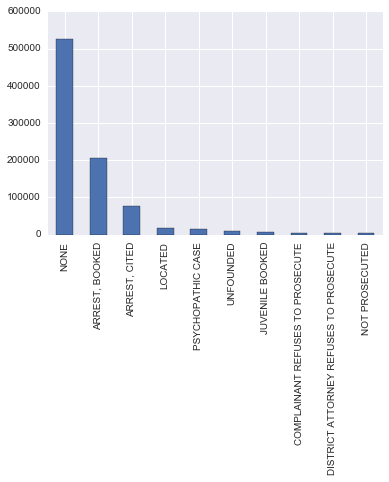

In [10]:
# Now, we try visualizing the top 10 Resolution
resolution_counts = df_train['Resolution'].value_counts()
print resolution_counts[:10]

# Plot the top 10 counts
resolution_counts[:10].plot(kind='bar')

GRAND THEFT FROM LOCKED AUTO                 60022
LOST PROPERTY                                31729
BATTERY                                      27441
STOLEN AUTOMOBILE                            26897
DRIVERS LICENSE, SUSPENDED OR REVOKED        26839
WARRANT ARREST                               23754
SUSPICIOUS OCCURRENCE                        21891
AIDED CASE, MENTAL DISTURBED                 21497
PETTY THEFT FROM LOCKED AUTO                 19771
MALICIOUS MISCHIEF, VANDALISM OF VEHICLES    17789
Name: Descript, dtype: int64


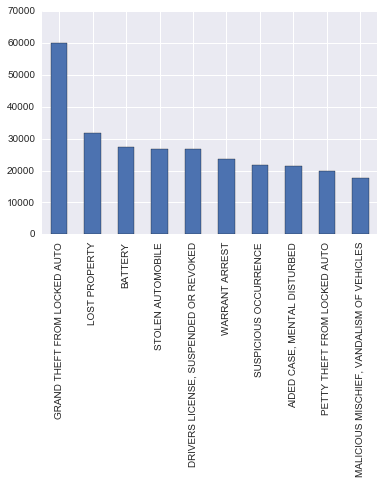

In [11]:
# Now, we try visualizing the top 10 Descript
description_counts = df_train['Descript'].value_counts()
print description_counts[:10]

# Plot the top 10 counts
description_counts[:10].plot(kind='bar')

800 Block of BRYANT ST             26533
800 Block of MARKET ST              6581
2000 Block of MISSION ST            5097
1000 Block of POTRERO AV            4063
900 Block of MARKET ST              3251
0 Block of TURK ST                  3228
0 Block of 6TH ST                   2884
300 Block of ELLIS ST               2703
400 Block of ELLIS ST               2590
16TH ST / MISSION ST                2504
1000 Block of MARKET ST             2489
1100 Block of MARKET ST             2319
2000 Block of MARKET ST             2168
100 Block of OFARRELL ST            2140
700 Block of MARKET ST              2081
3200 Block of 20TH AV               2035
100 Block of 6TH ST                 1887
500 Block of JOHNFKENNEDY DR        1824
TURK ST / TAYLOR ST                 1810
200 Block of TURK ST                1800
0 Block of PHELAN AV                1791
0 Block of UNITEDNATIONS PZ         1789
0 Block of POWELL ST                1717
100 Block of EDDY ST                1681
1400 Block of PH

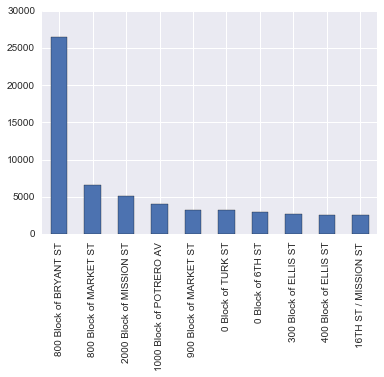

In [12]:
# Now, we try visualizing the top 10 Address
address_counts = df_train['Address'].value_counts()
#print address_counts[:10]
print address_counts

# Plot the top 10 counts
address_counts[:10].plot(kind='bar')

The Description, Resolution and Address have loads of unique values. Thus, feeding in raw values into a model would not make sense.
We will need to somehow simplify and preprocess the data to a more manageable format.
One possible solution for the Address is to reduce the address to their street/avenue names only.
A point to note here is that there are two different entries for the same address, namely 16TH ST / MISSION ST and MISSION ST / 16TH ST. This is probably caused by data entry errors, so we will fix them into one entry only. 
Then, dummy variables can be introduced for other categorical data.

In [4]:
# We remove the outliers before visualizing in a map
# Remove all +90 latitude data points
df_train = df_train[df_train.Y != 90]
display(df_train.describe())

,X,Y
count,877982.000000,877982.000000
mean,-122.422763,37.767035
std,0.025285,0.024165
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416420,37.775421
75%,-122.406959,37.784368
max,-122.364937,37.819975


In [4]:
# Detect outliers in the training dataset with Mean Absolute Deviation (MAD)
# http://eurekastatistics.com/using-the-median-absolute-deviation-to-find-outliers/

# Create a DataFrame from value_counts() Series
df_outlier = df_train['Category'].value_counts().to_frame(name='Counts')

# Calculate basic statistics of the DataFrame distribution
from statsmodels import robust
mad = robust.mad(df_outlier['Counts'])
median = np.median(df_outlier['Counts'])
mean = np.mean(df_outlier['Counts'])
std = np.std(df_outlier['Counts'])

# Since our distribution of Category is skewed, 
# we need to implement a double MAD approach to catch low and high outliers
mad_left = float(robust.mad(df_outlier[df_outlier['Counts'] < median]))
mad_right = float(robust.mad(df_outlier[df_outlier['Counts'] >= median]))
print mad_left, mad_right

# Add new columns for the outlier calculations
df_outlier['Z_score'] = df_outlier['Counts'].map(
    lambda x: abs(x - median) / mad_right if x >= median else np.absolute(x - median) / mad_left)

display(df_outlier.head())
display(df_outlier.describe())
df_outlier.loc[df_outlier['Z_score'] > 3]

1728.71418678 42551.4249722


,Counts,Z_score
LARCENY/THEFT,174885,4.006869
OTHER OFFENSES,126165,2.861902
NON-CRIMINAL,92300,2.066041
ASSAULT,76872,1.703468
DRUG/NARCOTIC,53971,1.165272


,Counts,Z_score
count,39.000000,39.000000
mean,22512.358974,1.305497
std,38071.035462,1.020326
min,6.000000,0.000000
25%,1195.500000,0.363137
50%,4387.000000,1.183539
75%,28700.500000,2.248781
max,174885.000000,4.006869


,Counts,Z_score
LARCENY/THEFT,174885,4.006869


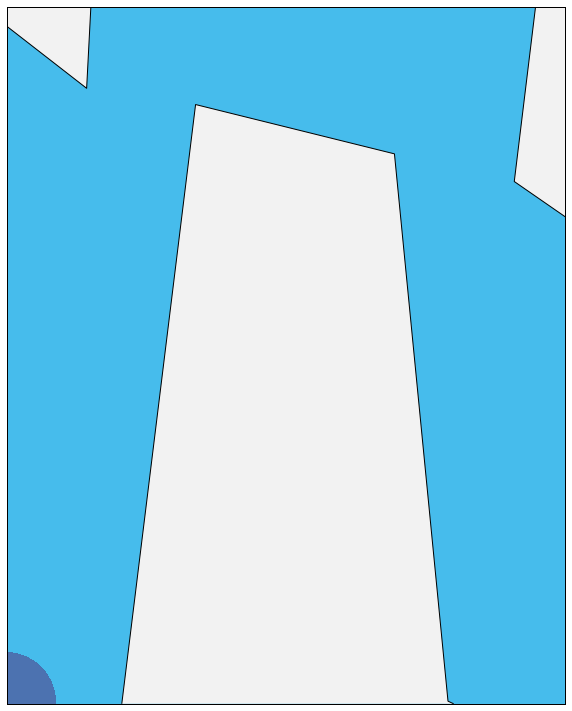

In [19]:
# Visualize crime categories in a map
# http://www.datadependence.com/2016/06/creating-map-visualisations-in-python/
# westlimit=-122.56485; southlimit=37.591927; eastlimit=-122.308731; northlimit=37.845037

fig, ax = plt.subplots(figsize=(10, 20))

m = Basemap(resolution='l', # 'c': crude, 'l': low, 'i': intermediate, 'h': high, 'f': full map resolution
            projection='merc', # Mercator type projection
            #lat_0=37.718482, lon_0=-122.436791, # Map center coordinates
            lat_0=37.771020, lon_0=-122.422763, # Map center coordinates
            llcrnrlon=-122.56485, llcrnrlat=37.591927, # Lower left corner coordinates 
            urcrnrlon=-122.308731, urcrnrlat=37.845037) # Upper right corner coordinates

# Define how the map is to be displayed
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2', lake_color='#46bcec')
m.drawcoastlines()
m.plot(df_train['X'], df_train['Y'], 'o', markersize=100)
plt.show()

# Data Preprocessing

In [5]:
# Proceed to delete the low-boundary outliers, whilst keeping the high outliers
df_train = df_train.loc[df_train['Category'] != 'BRIBERY']
df_train = df_train.loc[df_train['Category'] != 'EXTORTION']
df_train = df_train.loc[df_train['Category'] != 'SEX OFFENSES NON FORCIBLE']
df_train = df_train.loc[df_train['Category'] != 'GAMBLING']
df_train = df_train.loc[df_train['Category'] != 'PORNOGRAPHY/OBSCENE MAT']
df_train = df_train.loc[df_train['Category'] != 'TREA']

df_train['Category'].value_counts()

LARCENY/THEFT                  174885
OTHER OFFENSES                 126165
NON-CRIMINAL                    92300
ASSAULT                         76872
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53772
VANDALISM                       44724
WARRANTS                        42206
BURGLARY                        36754
SUSPICIOUS OCC                  31412
MISSING PERSON                  25989
ROBBERY                         22999
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7325
STOLEN PROPERTY                  4539
SEX OFFENSES FORCIBLE            4387
DISORDERLY CONDUCT               4318
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

In [5]:
# Fix data input errors for Address
# http://stackoverflow.com/questions/36909977/update-row-values-where-certain-condition-is-met-in-pandas
#df_train.loc[df_train['Address'] == 'MISSION ST / 16TH ST', ['Address']] = '16TH ST / MISSION ST'
#print df_train['Address'].value_counts()[:10]

800 Block of BRYANT ST      26491
800 Block of MARKET ST       6578
2000 Block of MISSION ST     5088
1000 Block of POTRERO AV     4056
16TH ST / MISSION ST         3804
900 Block of MARKET ST       3251
0 Block of TURK ST           3228
0 Block of 6TH ST            2879
300 Block of ELLIS ST        2700
400 Block of ELLIS ST        2585
Name: Address, dtype: int64


In [6]:
# Simplify Address to street names only
# http://stackoverflow.com/questions/4666973/how-to-extract-a-substring-from-inside-a-string-in-python
# http://stackoverflow.com/questions/12376863/adding-calculated-columns-to-a-dataframe-in-pandas

# Apply a regex function across all rows
# First group ([0-9A-Z]+): Any alphanumeric caps (for the street name)
# Second group \s([A-Z]{2}): Whitespace followed by a two letter caps (for ST, AV, RD abbreviations)
# Third group |([A-Z-0-9]{4})$: Or match any 4 char alphanumeric at end of string
#df_train['Address'] = df_train.apply(lambda row: re.search('([0-9A-Z]+)\s([A-Z]{2})|([A-Z-0-9]{4})$',row['Address']).group(0), axis=1)

#print df_train['Address'].value_counts()[:10]

MISSION ST     35393
MARKET ST      35078
BRYANT ST      29952
TURK ST        15569
EDDY ST        13143
ELLIS ST       12520
3RD ST         12137
16TH ST        11776
OFARRELL ST    11321
6TH ST          9720
Name: Address, dtype: int64


In [6]:
# Check the datatypes of all columns
print df_train.dtypes

Dates          object
Category       object
Descript       object
DayOfWeek      object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
dtype: object


In [6]:
# Convert Dates column to the correct dtype
df_train['Dates'] = df_train['Dates'].astype('datetime64[ns]')
print df_train.dtypes

Dates         datetime64[ns]
Category              object
Descript              object
DayOfWeek             object
PdDistrict            object
Resolution            object
Address               object
X                    float64
Y                    float64
dtype: object


Before creating dummy variables, we would like to drop unnecessary columns for model training.
Namely, these columns are Descript and Resolution. If we were to create dummy variables for all categorical columns, then we would end up with a huge table which takes up a lot of memory and space.

,X,Y
count,877115.000000,877115.000000
mean,4.807480,3.631437
std,0.000206,0.000640
min,4.807008,3.629869
25%,4.807351,3.631050
50%,4.807429,3.631659
75%,4.807564,3.631895
max,4.808222,3.632837


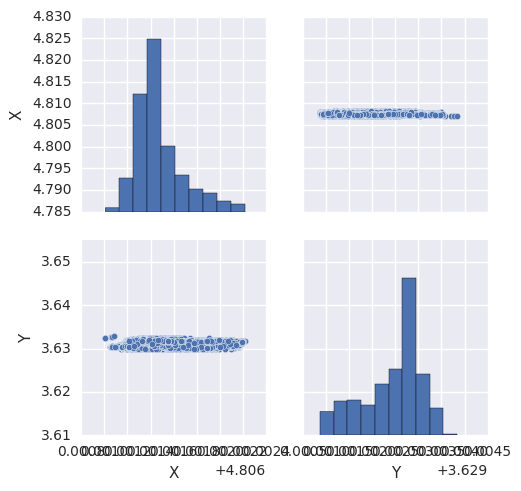

In [7]:
# Convert longitude and latitude into natural log to spread out the skewness
df_train['X'] = df_train['X'].map(lambda x: np.log(-x))
df_train['Y'] = df_train['Y'].map(lambda x: np.log(x))

display(df_train.describe())
sns.pairplot(df_train)

In [8]:
# Extract time from Dates and add a new column TimeOfDay representing Day/Night
# Day: 6:00AM - 5:59PM, Night: 6:00PM - 5:59AM
from datetime import datetime

time_of_day = []
start_t = datetime.strptime('06:00', '%H:%M').time()
end_t = datetime.strptime('18:00', '%H:%M').time()

for row in df_train['Dates']:
    if start_t <= row.time() < end_t:
        time_of_day.append('Day')
    else:
        time_of_day.append('Night')
        
df_train['TimeOfDay'] = time_of_day

display(df_train.head())

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,TimeOfDay
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,4.807506,3.631637,Night
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,4.807506,3.631637,Night
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,4.807493,3.632320,Night
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,4.807515,3.632332,Night
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,4.807611,3.631556,Night


In [9]:
# Drop Descript, Resolution, Date columns
df_train.drop(['Descript', 'Resolution', 'Dates'], axis=1, inplace=True)

print df_train.dtypes

Category       object
DayOfWeek      object
PdDistrict     object
Address        object
X             float64
Y             float64
TimeOfDay      object
dtype: object


In [10]:
# Create dummy variables for all categorical features in training set
df_X1 = pd.get_dummies(df_train['DayOfWeek'], prefix = 'Day')
df_X2 = pd.get_dummies(df_train['PdDistrict'], prefix = 'PD')
df_X3 = pd.get_dummies(df_train['TimeOfDay'], prefix = 'Time')
#df_X4 = pd.get_dummies(df_train['Address'], prefix = 'Add') # Not enough memory to execute

df_train = df_train.join(df_X1)
df_train = df_train.join(df_X2)
df_train = df_train.join(df_X3)
df_train.drop(['DayOfWeek', 'PdDistrict', 'TimeOfDay'], axis = 1, inplace = True)
print "Processed feature columns ({} total features):\n{}".format(len(df_train.columns), list(df_train.columns))

Processed feature columns (23 total features):
['Category', 'Address', 'X', 'Y', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday', 'PD_BAYVIEW', 'PD_CENTRAL', 'PD_INGLESIDE', 'PD_MISSION', 'PD_NORTHERN', 'PD_PARK', 'PD_RICHMOND', 'PD_SOUTHERN', 'PD_TARAVAL', 'PD_TENDERLOIN', 'Time_Day', 'Time_Night']


In [12]:
# Since we are unable to preprocess Address, we will drop them for the model training
# Drop Address column
df_train.drop(['Address'], axis = 1, inplace = True)

print df_train.dtypes

Category          object
X                float64
Y                float64
Day_Friday       float64
Day_Monday       float64
Day_Saturday     float64
Day_Sunday       float64
Day_Thursday     float64
Day_Tuesday      float64
Day_Wednesday    float64
PD_BAYVIEW       float64
PD_CENTRAL       float64
PD_INGLESIDE     float64
PD_MISSION       float64
PD_NORTHERN      float64
PD_PARK          float64
PD_RICHMOND      float64
PD_SOUTHERN      float64
PD_TARAVAL       float64
PD_TENDERLOIN    float64
Time_Day         float64
Time_Night       float64
dtype: object


In [13]:
# Saves preprocessed dataset into pickle
df_train.to_pickle('preprocess_2.pickle')